In [ ]:
import zipfile
import tarfile
import gzip
import requests
import os

In [ ]:
def download_file(url, save_path):
    # Send a request
    response = requests.get(url, stream=True)
    # Check the response status code
    if response.status_code == 200:
        # Open the file in binary write mode
        with open(save_path, 'wb') as f:
            # Write the file chunk by chunk
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)
        print("File downloaded successfully")
    else:
        print("Download failed. Status code:", response.status_code)

def extract_tar(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar file
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

def extract_tar_gz(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar.gz file
    with gzip.open(file_path, 'rb') as gz:
        with tarfile.open(fileobj=gz, mode='r') as tar:
            tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

In [ ]:
caltech101_url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
download_path = '/content/downloads'
caltech101_path = download_path + '/caltech-101.zip'

if not os.path.exists(download_path):
  os.makedirs(download_path)

download_file(caltech101_url, caltech101_path)

File downloaded successfully


In [ ]:
extract_path = download_path + '/extract'
if not os.path.exists(extract_path):
  os.makedirs(extract_path)
with zipfile.ZipFile(caltech101_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
dataset_path = '/content/data'
if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)
extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', dataset_path)

Extracted '/content/downloads/extract/caltech-101/101_ObjectCategories.tar.gz' to '/content/data'


In [ ]:
image_path = dataset_path + '/101_ObjectCategories'

label_list = os.listdir(image_path)
label_list = [item for item in label_list if item!='BACKGROUND_Google']
label_path = [image_path + '/' + item for item in label_list]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cuda


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
images = []
labels = []

for i in range(len(label_path)):
  folder_path = label_path[i]
#for folder_path in label_path:
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    #print(file_path)
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
      img = Image.open(file_path)
      if img.mode != 'RGB':
        img = img.convert('RGB')
      img_transformed = transform(img)
      images.append(img_transformed)
      labels.append(i)

labels = torch.tensor(labels)
train_data, test_data, train_targets, test_targets = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
class SparseConvNetDataset(Dataset):
  def __init__(self, data, targets, device, mask):
    self.data = data.copy()
    self.targets = targets
    self.mask = mask
    if type(mask) != int:
        for i in range(len(self.data)):
            self.data[i] = self.data[i] * mask[i]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = torch.cat((self.data[idx], self.mask[idx].unsqueeze(0)), dim=0)
    data = data.to(device)
    targets = self.targets[idx].to(device)
    return data, targets

In [ ]:
class SparseConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(SparseConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False)

    self.bias = nn.Parameter(
      torch.zeros(out_channels),
      requires_grad=True)

    self.sparsity = nn.Conv2d(
      in_channels=1,
      out_channels=1,
      kernel_size=kernel_size,
      padding=padding,
      dilation=dilation,
      bias=False)
    kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)
    self.sparsity.weight = nn.Parameter(
      data=kernel,
      requires_grad=False)

    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(2, 2)
    self.norm = nn.BatchNorm2d(out_channels)

  def forward(self, x, mask):
    x = self.conv(x * mask)
    normalizer = self.sparsity(mask) + 1e-8
    x = x / normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    x = self.relu(x)
    x = self.pool(x)
    x = self.norm(x)
    mask = self.pool(mask)
    return x, mask


In [ ]:
class SparseConvNet(nn.Module):
    def __init__(self):
      super(SparseConvNet, self).__init__()
      self.conv1 = SparseConvBlock(3, 6, 7, padding='same')
      self.conv2 = SparseConvBlock(6, 16, 5, padding='same')
      self.conv3 = SparseConvBlock(16, 16, 3, padding='same')
      self.conv4 = SparseConvBlock(16, 16, 3, padding='same')


      self.fc1 = nn.Linear(16 * 14 * 14, 240)
      self.fc2 = nn.Linear(240, 120)
      self.fc3 = nn.Linear(120, 101)

    def forward(self, x):
      mask = x[:, -1:, :, :]
      x = x[:, :-1, :, :]

      x, mask = self.conv1(x, mask)
      x, mask = self.conv2(x, mask)
      x, mask = self.conv3(x, mask)
      x, mask = self.conv4(x, mask)

      x = x.view(-1, 16 * 14 * 14)
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
def model_test(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [ ]:
prob = 0.3
batch_size = 64

train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))

trainset = SparseConvNetDataset(train_data, train_targets, device, train_mask)
testset = SparseConvNetDataset(test_data, test_targets, device, test_mask)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

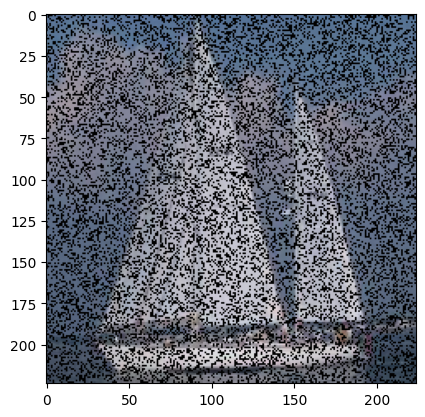

In [ ]:
plt.imshow(testset[0][0][:3].cpu().permute(1, 2, 0))

In [ ]:
net = SparseConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
acc_sparseconv = []

for epoch in tqdm(range(50)):
    if epoch==25:
          optimizer = optim.Adam(net.parameters(), lr=0.0001)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs, labels = data
      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    acc_sparseconv.append(model_test(net, testloader))
    print('acc: %.3f' % acc_sparseconv[epoch])
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

[1,    20] loss: 4.00346
[1,    40] loss: 3.35188
[1,    60] loss: 3.03149
[1,    80] loss: 2.76934
[1,   100] loss: 2.70833


  2%|▏         | 1/50 [00:11<09:34, 11.72s/it]

acc: 0.441
[2,    20] loss: 2.13773
[2,    40] loss: 2.15697
[2,    60] loss: 2.08065
[2,    80] loss: 2.00153
[2,   100] loss: 1.80710


  4%|▍         | 2/50 [00:21<08:23, 10.49s/it]

acc: 0.514
[3,    20] loss: 1.27371
[3,    40] loss: 1.19251
[3,    60] loss: 1.26350
[3,    80] loss: 1.28555
[3,   100] loss: 1.24360


  6%|▌         | 3/50 [00:30<07:51, 10.02s/it]

acc: 0.559
[4,    20] loss: 0.69200
[4,    40] loss: 0.61198
[4,    60] loss: 0.67089
[4,    80] loss: 0.62382
[4,   100] loss: 0.61424


  8%|▊         | 4/50 [00:40<07:37,  9.94s/it]

acc: 0.590
[5,    20] loss: 0.28906
[5,    40] loss: 0.24977
[5,    60] loss: 0.28331
[5,    80] loss: 0.22444
[5,   100] loss: 0.25524


 10%|█         | 5/50 [00:50<07:22,  9.83s/it]

acc: 0.579
[6,    20] loss: 0.10795
[6,    40] loss: 0.08283
[6,    60] loss: 0.08456
[6,    80] loss: 0.07358
[6,   100] loss: 0.07850


 12%|█▏        | 6/50 [00:59<07:10,  9.78s/it]

acc: 0.598
[7,    20] loss: 0.02483
[7,    40] loss: 0.02476
[7,    60] loss: 0.02768
[7,    80] loss: 0.02449
[7,   100] loss: 0.02173


 14%|█▍        | 7/50 [01:09<06:59,  9.76s/it]

acc: 0.614
[8,    20] loss: 0.01984
[8,    40] loss: 0.00783
[8,    60] loss: 0.00686
[8,    80] loss: 0.00680
[8,   100] loss: 0.00976


 16%|█▌        | 8/50 [01:19<06:51,  9.79s/it]

acc: 0.615
[9,    20] loss: 0.00398
[9,    40] loss: 0.00383
[9,    60] loss: 0.00370
[9,    80] loss: 0.00327
[9,   100] loss: 0.00324


 18%|█▊        | 9/50 [01:29<06:41,  9.79s/it]

acc: 0.619
[10,    20] loss: 0.00291
[10,    40] loss: 0.00266
[10,    60] loss: 0.00276
[10,    80] loss: 0.00222
[10,   100] loss: 0.00444


 20%|██        | 10/50 [01:39<06:31,  9.79s/it]

acc: 0.617
[11,    20] loss: 0.00236
[11,    40] loss: 0.00239
[11,    60] loss: 0.00190
[11,    80] loss: 0.00337
[11,   100] loss: 0.00210


 22%|██▏       | 11/50 [01:48<06:22,  9.82s/it]

acc: 0.625
[12,    20] loss: 0.00172
[12,    40] loss: 0.00214
[12,    60] loss: 0.00160
[12,    80] loss: 0.00180
[12,   100] loss: 0.00166


 24%|██▍       | 12/50 [01:59<06:16,  9.92s/it]

acc: 0.623
[13,    20] loss: 0.00137
[13,    40] loss: 0.00125
[13,    60] loss: 0.00127
[13,    80] loss: 0.00123
[13,   100] loss: 0.00145


 26%|██▌       | 13/50 [02:09<06:07,  9.94s/it]

acc: 0.623
[14,    20] loss: 0.00113
[14,    40] loss: 0.00121
[14,    60] loss: 0.00105
[14,    80] loss: 0.00110
[14,   100] loss: 0.00107


 28%|██▊       | 14/50 [02:19<05:58,  9.95s/it]

acc: 0.625
[15,    20] loss: 0.00090
[15,    40] loss: 0.00105
[15,    60] loss: 0.00101
[15,    80] loss: 0.00092
[15,   100] loss: 0.00104


 30%|███       | 15/50 [02:29<05:48,  9.97s/it]

acc: 0.624
[16,    20] loss: 0.00089
[16,    40] loss: 0.00080
[16,    60] loss: 0.00082
[16,    80] loss: 0.00102
[16,   100] loss: 0.00084


 32%|███▏      | 16/50 [02:39<05:39, 10.00s/it]

acc: 0.623
[17,    20] loss: 0.00079
[17,    40] loss: 0.00073
[17,    60] loss: 0.00073
[17,    80] loss: 0.00081
[17,   100] loss: 0.00080


 34%|███▍      | 17/50 [02:49<05:31, 10.03s/it]

acc: 0.624
[18,    20] loss: 0.00065
[18,    40] loss: 0.00065
[18,    60] loss: 0.00069
[18,    80] loss: 0.00065
[18,   100] loss: 0.00069


 36%|███▌      | 18/50 [02:59<05:20, 10.01s/it]

acc: 0.627
[19,    20] loss: 0.00066
[19,    40] loss: 0.00060
[19,    60] loss: 0.00062
[19,    80] loss: 0.00062
[19,   100] loss: 0.00056


 38%|███▊      | 19/50 [03:08<05:07,  9.93s/it]

acc: 0.626
[20,    20] loss: 0.00057
[20,    40] loss: 0.00055
[20,    60] loss: 0.00063
[20,    80] loss: 0.00055
[20,   100] loss: 0.00054


 40%|████      | 20/50 [03:18<04:58,  9.94s/it]

acc: 0.627
[21,    20] loss: 0.00049
[21,    40] loss: 0.00048
[21,    60] loss: 0.00049
[21,    80] loss: 0.00050
[21,   100] loss: 0.00046


 42%|████▏     | 21/50 [03:28<04:48,  9.94s/it]

acc: 0.630
[22,    20] loss: 0.00041
[22,    40] loss: 0.00043
[22,    60] loss: 0.00042
[22,    80] loss: 0.00041
[22,   100] loss: 0.00047


 44%|████▍     | 22/50 [03:38<04:38,  9.96s/it]

acc: 0.626
[23,    20] loss: 0.00041
[23,    40] loss: 0.00038
[23,    60] loss: 0.00037
[23,    80] loss: 0.00046
[23,   100] loss: 0.00039


 46%|████▌     | 23/50 [03:48<04:29,  9.97s/it]

acc: 0.627
[24,    20] loss: 0.00036
[24,    40] loss: 0.00036
[24,    60] loss: 0.00035
[24,    80] loss: 0.00034
[24,   100] loss: 0.00034


 48%|████▊     | 24/50 [03:58<04:20, 10.00s/it]

acc: 0.626
[25,    20] loss: 0.00033
[25,    40] loss: 0.00032
[25,    60] loss: 0.00034
[25,    80] loss: 0.00035
[25,   100] loss: 0.00032


 50%|█████     | 25/50 [04:09<04:10, 10.03s/it]

acc: 0.626
[26,    20] loss: 0.00037
[26,    40] loss: 0.00037
[26,    60] loss: 0.00034
[26,    80] loss: 0.00037
[26,   100] loss: 0.00037


 52%|█████▏    | 26/50 [04:19<04:00, 10.01s/it]

acc: 0.624
[27,    20] loss: 0.00022
[27,    40] loss: 0.00020
[27,    60] loss: 0.00019
[27,    80] loss: 0.00018
[27,   100] loss: 0.00019


 54%|█████▍    | 27/50 [04:29<03:50, 10.00s/it]

acc: 0.626
[28,    20] loss: 0.00023
[28,    40] loss: 0.00049
[28,    60] loss: 0.00053
[28,    80] loss: 0.00028
[28,   100] loss: 0.00025


 56%|█████▌    | 28/50 [04:39<03:40, 10.02s/it]

acc: 0.619
[29,    20] loss: 0.00031
[29,    40] loss: 0.00210
[29,    60] loss: 0.00111
[29,    80] loss: 0.00144
[29,   100] loss: 0.00160


 58%|█████▊    | 29/50 [04:49<03:30, 10.03s/it]

acc: 0.605
[30,    20] loss: 0.00098
[30,    40] loss: 0.00063
[30,    60] loss: 0.00026
[30,    80] loss: 0.00025
[30,   100] loss: 0.00023


 60%|██████    | 30/50 [04:59<03:20, 10.01s/it]

acc: 0.619
[31,    20] loss: 0.00016
[31,    40] loss: 0.00015
[31,    60] loss: 0.00014
[31,    80] loss: 0.00013
[31,   100] loss: 0.00014


 62%|██████▏   | 31/50 [05:09<03:10, 10.00s/it]

acc: 0.623
[32,    20] loss: 0.00012
[32,    40] loss: 0.00015
[32,    60] loss: 0.00010
[32,    80] loss: 0.00014
[32,   100] loss: 0.00012


 64%|██████▍   | 32/50 [05:19<03:00, 10.04s/it]

acc: 0.626
[33,    20] loss: 0.00011
[33,    40] loss: 0.00012
[33,    60] loss: 0.00010
[33,    80] loss: 0.00011
[33,   100] loss: 0.00010


 66%|██████▌   | 33/50 [05:29<02:50, 10.02s/it]

acc: 0.624
[34,    20] loss: 0.00010
[34,    40] loss: 0.00009
[34,    60] loss: 0.00008
[34,    80] loss: 0.00009
[34,   100] loss: 0.00009


 68%|██████▊   | 34/50 [05:39<02:40, 10.01s/it]

acc: 0.624
[35,    20] loss: 0.00011
[35,    40] loss: 0.00010
[35,    60] loss: 0.00008
[35,    80] loss: 0.00008
[35,   100] loss: 0.00009


 70%|███████   | 35/50 [05:49<02:30, 10.01s/it]

acc: 0.627
[36,    20] loss: 0.00007
[36,    40] loss: 0.00008
[36,    60] loss: 0.00008
[36,    80] loss: 0.00007
[36,   100] loss: 0.00008


 72%|███████▏  | 36/50 [05:59<02:20, 10.01s/it]

acc: 0.627
[37,    20] loss: 0.00007
[37,    40] loss: 0.00007
[37,    60] loss: 0.00007
[37,    80] loss: 0.00007
[37,   100] loss: 0.00008


 74%|███████▍  | 37/50 [06:09<02:10, 10.01s/it]

acc: 0.625
[38,    20] loss: 0.00006
[38,    40] loss: 0.00006
[38,    60] loss: 0.00007
[38,    80] loss: 0.00007
[38,   100] loss: 0.00006


 76%|███████▌  | 38/50 [06:19<02:00, 10.03s/it]

acc: 0.624
[39,    20] loss: 0.00007
[39,    40] loss: 0.00006
[39,    60] loss: 0.00006
[39,    80] loss: 0.00007
[39,   100] loss: 0.00006


 78%|███████▊  | 39/50 [06:29<01:50, 10.05s/it]

acc: 0.627
[40,    20] loss: 0.00006
[40,    40] loss: 0.00007
[40,    60] loss: 0.00007
[40,    80] loss: 0.00005
[40,   100] loss: 0.00006


 80%|████████  | 40/50 [06:39<01:40, 10.05s/it]

acc: 0.627
[41,    20] loss: 0.00005
[41,    40] loss: 0.00006
[41,    60] loss: 0.00005
[41,    80] loss: 0.00005
[41,   100] loss: 0.00005


 82%|████████▏ | 41/50 [06:49<01:30, 10.08s/it]

acc: 0.628
[42,    20] loss: 0.00006
[42,    40] loss: 0.00005
[42,    60] loss: 0.00005
[42,    80] loss: 0.00005
[42,   100] loss: 0.00004


 84%|████████▍ | 42/50 [06:59<01:20, 10.10s/it]

acc: 0.625
[43,    20] loss: 0.00004
[43,    40] loss: 0.00005
[43,    60] loss: 0.00005
[43,    80] loss: 0.00004
[43,   100] loss: 0.00006


 86%|████████▌ | 43/50 [07:09<01:10, 10.08s/it]

acc: 0.627
[44,    20] loss: 0.00004
[44,    40] loss: 0.00004
[44,    60] loss: 0.00004
[44,    80] loss: 0.00004
[44,   100] loss: 0.00005


 88%|████████▊ | 44/50 [07:19<01:00, 10.05s/it]

acc: 0.627
[45,    20] loss: 0.00004
[45,    40] loss: 0.00004
[45,    60] loss: 0.00004
[45,    80] loss: 0.00004
[45,   100] loss: 0.00004


 90%|█████████ | 45/50 [07:29<00:50, 10.04s/it]

acc: 0.628
[46,    20] loss: 0.00004
[46,    40] loss: 0.00004
[46,    60] loss: 0.00004
[46,    80] loss: 0.00004
[46,   100] loss: 0.00004


 92%|█████████▏| 46/50 [07:39<00:40, 10.03s/it]

acc: 0.628
[47,    20] loss: 0.00003
[47,    40] loss: 0.00004
[47,    60] loss: 0.00004
[47,    80] loss: 0.00004
[47,   100] loss: 0.00004


 94%|█████████▍| 47/50 [07:49<00:30, 10.03s/it]

acc: 0.627
[48,    20] loss: 0.00004
[48,    40] loss: 0.00004
[48,    60] loss: 0.00003
[48,    80] loss: 0.00003
[48,   100] loss: 0.00004


 96%|█████████▌| 48/50 [07:59<00:19,  9.96s/it]

acc: 0.632
[49,    20] loss: 0.00013
[49,    40] loss: 0.00008
[49,    60] loss: 0.00006
[49,    80] loss: 0.00005
[49,   100] loss: 0.00004


 98%|█████████▊| 49/50 [08:09<00:09,  9.97s/it]

acc: 0.630
[50,    20] loss: 0.00004
[50,    40] loss: 0.00003
[50,    60] loss: 0.00003
[50,    80] loss: 0.00003
[50,   100] loss: 0.00003


100%|██████████| 50/50 [08:19<00:00,  9.99s/it]

acc: 0.628
Finished Training


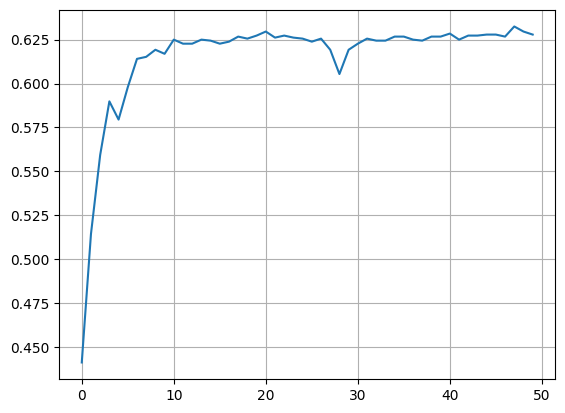

In [ ]:
plt.plot(acc_sparseconv)
plt.grid()

  0%|          | 0/20 [00:00<?, ?it/s]

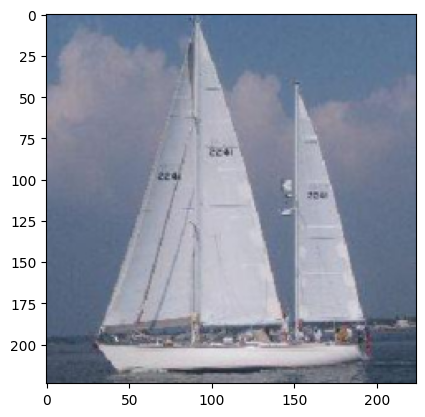

loss: 2.92583
[Sparsity: 0.00, Epoch: 1]acc: 0.413
loss: 1.58245
[Sparsity: 0.00, Epoch: 2]acc: 0.542
loss: 0.75252
[Sparsity: 0.00, Epoch: 3]acc: 0.630
loss: 0.26025
[Sparsity: 0.00, Epoch: 4]acc: 0.601
loss: 0.06872
[Sparsity: 0.00, Epoch: 5]acc: 0.609
loss: 0.01488
[Sparsity: 0.00, Epoch: 6]acc: 0.675
loss: 0.00745
[Sparsity: 0.00, Epoch: 7]acc: 0.677
loss: 0.00494
[Sparsity: 0.00, Epoch: 8]acc: 0.675
loss: 0.00450
[Sparsity: 0.00, Epoch: 9]acc: 0.681
loss: 0.00395
[Sparsity: 0.00, Epoch: 10]acc: 0.670
Finished Training


  5%|▌         | 1/20 [01:44<33:05, 104.48s/it]

[Sparsity: 0.00]acc: 0.670


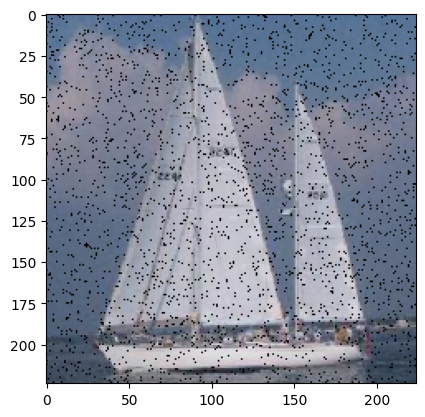

loss: 3.04660
[Sparsity: 0.05, Epoch: 1]acc: 0.401
loss: 1.75077
[Sparsity: 0.05, Epoch: 2]acc: 0.507
loss: 0.94417
[Sparsity: 0.05, Epoch: 3]acc: 0.571
loss: 0.36079
[Sparsity: 0.05, Epoch: 4]acc: 0.599
loss: 0.08018
[Sparsity: 0.05, Epoch: 5]acc: 0.621
loss: 0.01533
[Sparsity: 0.05, Epoch: 6]acc: 0.632
loss: 0.00646
[Sparsity: 0.05, Epoch: 7]acc: 0.632
loss: 0.00439
[Sparsity: 0.05, Epoch: 8]acc: 0.635
loss: 0.00324
[Sparsity: 0.05, Epoch: 9]acc: 0.635
loss: 0.00242
[Sparsity: 0.05, Epoch: 10]acc: 0.634
Finished Training


 10%|█         | 2/20 [03:26<30:59, 103.32s/it]

[Sparsity: 0.05]acc: 0.634


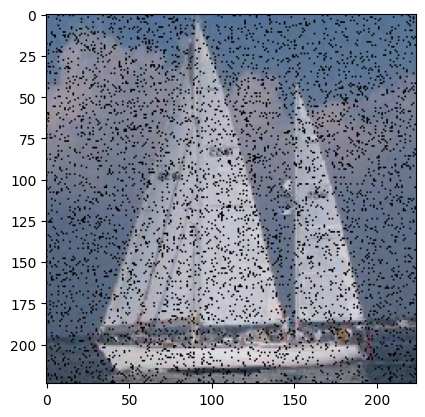

loss: 3.02859
[Sparsity: 0.10, Epoch: 1]acc: 0.431
loss: 1.81486
[Sparsity: 0.10, Epoch: 2]acc: 0.544
loss: 1.03131
[Sparsity: 0.10, Epoch: 3]acc: 0.540
loss: 0.47155
[Sparsity: 0.10, Epoch: 4]acc: 0.605
loss: 0.16207
[Sparsity: 0.10, Epoch: 5]acc: 0.599
loss: 0.03158
[Sparsity: 0.10, Epoch: 6]acc: 0.645
loss: 0.01374
[Sparsity: 0.10, Epoch: 7]acc: 0.645
loss: 0.00873
[Sparsity: 0.10, Epoch: 8]acc: 0.647
loss: 0.00645
[Sparsity: 0.10, Epoch: 9]acc: 0.649
loss: 0.00485
[Sparsity: 0.10, Epoch: 10]acc: 0.651
Finished Training


 15%|█▌        | 3/20 [05:10<29:19, 103.50s/it]

[Sparsity: 0.10]acc: 0.651


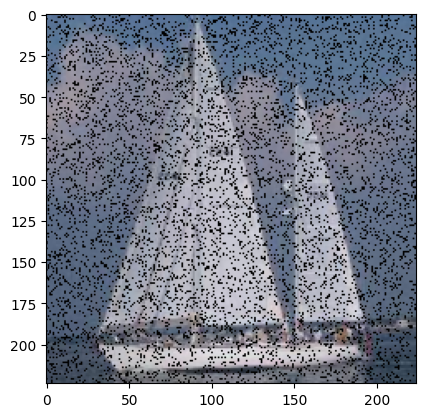

loss: 3.14748
[Sparsity: 0.15, Epoch: 1]acc: 0.419
loss: 1.96080
[Sparsity: 0.15, Epoch: 2]acc: 0.499
loss: 1.16556
[Sparsity: 0.15, Epoch: 3]acc: 0.498
loss: 0.54254
[Sparsity: 0.15, Epoch: 4]acc: 0.538
loss: 0.17921
[Sparsity: 0.15, Epoch: 5]acc: 0.608
loss: 0.03242
[Sparsity: 0.15, Epoch: 6]acc: 0.634
loss: 0.01380
[Sparsity: 0.15, Epoch: 7]acc: 0.637
loss: 0.00887
[Sparsity: 0.15, Epoch: 8]acc: 0.640
loss: 0.00652
[Sparsity: 0.15, Epoch: 9]acc: 0.640
loss: 0.00473
[Sparsity: 0.15, Epoch: 10]acc: 0.641
Finished Training


 20%|██        | 4/20 [06:54<27:39, 103.69s/it]

[Sparsity: 0.15]acc: 0.641


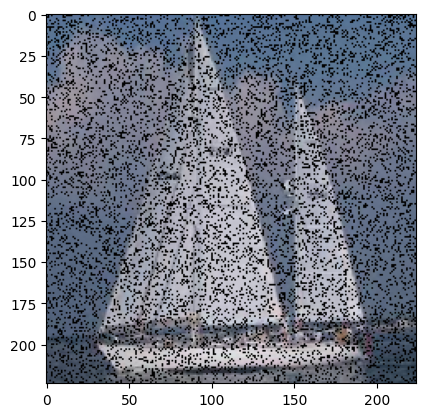

loss: 3.16850
[Sparsity: 0.20, Epoch: 1]acc: 0.384
loss: 1.98775
[Sparsity: 0.20, Epoch: 2]acc: 0.538
loss: 1.18086
[Sparsity: 0.20, Epoch: 3]acc: 0.581
loss: 0.58695
[Sparsity: 0.20, Epoch: 4]acc: 0.570
loss: 0.23666
[Sparsity: 0.20, Epoch: 5]acc: 0.593
loss: 0.05281
[Sparsity: 0.20, Epoch: 6]acc: 0.635
loss: 0.02457
[Sparsity: 0.20, Epoch: 7]acc: 0.632
loss: 0.01604
[Sparsity: 0.20, Epoch: 8]acc: 0.634
loss: 0.01165
[Sparsity: 0.20, Epoch: 9]acc: 0.640
loss: 0.00910
[Sparsity: 0.20, Epoch: 10]acc: 0.636
Finished Training


 25%|██▌       | 5/20 [08:37<25:50, 103.34s/it]

[Sparsity: 0.20]acc: 0.636


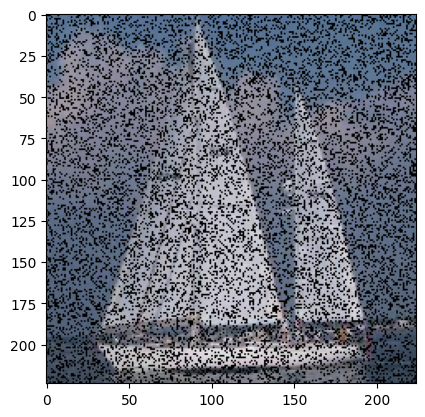

loss: 3.11394
[Sparsity: 0.25, Epoch: 1]acc: 0.421
loss: 1.96318
[Sparsity: 0.25, Epoch: 2]acc: 0.514
loss: 1.14954
[Sparsity: 0.25, Epoch: 3]acc: 0.463
loss: 0.53373
[Sparsity: 0.25, Epoch: 4]acc: 0.579
loss: 0.16927
[Sparsity: 0.25, Epoch: 5]acc: 0.596
loss: 0.03335
[Sparsity: 0.25, Epoch: 6]acc: 0.624
loss: 0.01425
[Sparsity: 0.25, Epoch: 7]acc: 0.628
loss: 0.00931
[Sparsity: 0.25, Epoch: 8]acc: 0.631
loss: 0.00674
[Sparsity: 0.25, Epoch: 9]acc: 0.627
loss: 0.00514
[Sparsity: 0.25, Epoch: 10]acc: 0.623
Finished Training


 30%|███       | 6/20 [10:22<24:16, 104.04s/it]

[Sparsity: 0.25]acc: 0.623


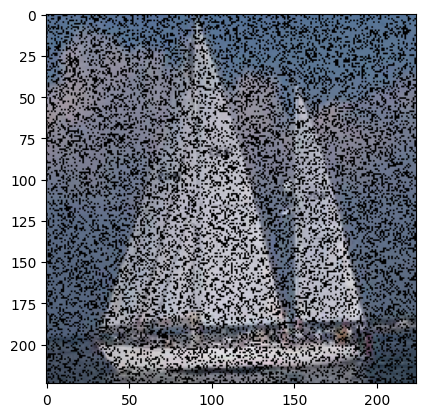

loss: 3.07841
[Sparsity: 0.30, Epoch: 1]acc: 0.437
loss: 1.91145
[Sparsity: 0.30, Epoch: 2]acc: 0.537
loss: 1.09413
[Sparsity: 0.30, Epoch: 3]acc: 0.529
loss: 0.49291
[Sparsity: 0.30, Epoch: 4]acc: 0.593
loss: 0.14041
[Sparsity: 0.30, Epoch: 5]acc: 0.601
loss: 0.02842
[Sparsity: 0.30, Epoch: 6]acc: 0.626
loss: 0.01295
[Sparsity: 0.30, Epoch: 7]acc: 0.625
loss: 0.00824
[Sparsity: 0.30, Epoch: 8]acc: 0.623
loss: 0.00592
[Sparsity: 0.30, Epoch: 9]acc: 0.631
loss: 0.00469
[Sparsity: 0.30, Epoch: 10]acc: 0.628
Finished Training


 35%|███▌      | 7/20 [12:06<22:32, 104.07s/it]

[Sparsity: 0.30]acc: 0.628


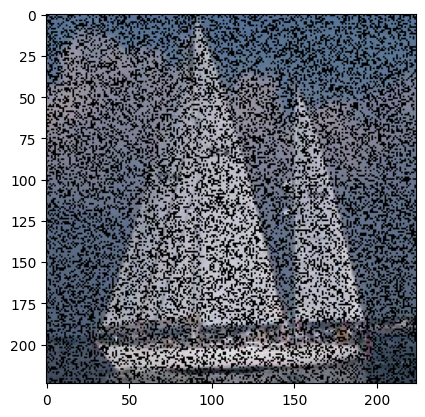

loss: 3.11853
[Sparsity: 0.35, Epoch: 1]acc: 0.454
loss: 1.89897
[Sparsity: 0.35, Epoch: 2]acc: 0.537
loss: 1.08466
[Sparsity: 0.35, Epoch: 3]acc: 0.564
loss: 0.49361
[Sparsity: 0.35, Epoch: 4]acc: 0.579
loss: 0.16084
[Sparsity: 0.35, Epoch: 5]acc: 0.586
loss: 0.03345
[Sparsity: 0.35, Epoch: 6]acc: 0.638
loss: 0.01454
[Sparsity: 0.35, Epoch: 7]acc: 0.631
loss: 0.00981
[Sparsity: 0.35, Epoch: 8]acc: 0.635
loss: 0.00732
[Sparsity: 0.35, Epoch: 9]acc: 0.638
loss: 0.00541
[Sparsity: 0.35, Epoch: 10]acc: 0.638
Finished Training


 40%|████      | 8/20 [13:52<20:53, 104.48s/it]

[Sparsity: 0.35]acc: 0.638


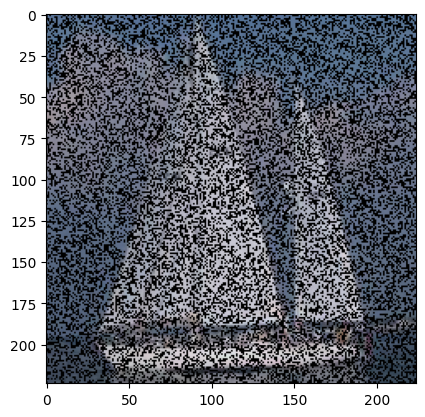

loss: 3.21380
[Sparsity: 0.40, Epoch: 1]acc: 0.374
loss: 2.13915
[Sparsity: 0.40, Epoch: 2]acc: 0.434
loss: 1.36607
[Sparsity: 0.40, Epoch: 3]acc: 0.526
loss: 0.74129
[Sparsity: 0.40, Epoch: 4]acc: 0.556
loss: 0.29189
[Sparsity: 0.40, Epoch: 5]acc: 0.528
loss: 0.06219
[Sparsity: 0.40, Epoch: 6]acc: 0.596
loss: 0.03018
[Sparsity: 0.40, Epoch: 7]acc: 0.599
loss: 0.01896
[Sparsity: 0.40, Epoch: 8]acc: 0.597
loss: 0.01382
[Sparsity: 0.40, Epoch: 9]acc: 0.599
loss: 0.01011
[Sparsity: 0.40, Epoch: 10]acc: 0.600
Finished Training


 45%|████▌     | 9/20 [15:37<19:11, 104.72s/it]

[Sparsity: 0.40]acc: 0.600


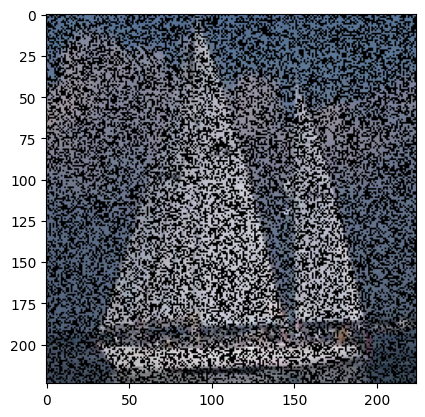

loss: 3.17672
[Sparsity: 0.45, Epoch: 1]acc: 0.401
loss: 2.06108
[Sparsity: 0.45, Epoch: 2]acc: 0.507
loss: 1.21894
[Sparsity: 0.45, Epoch: 3]acc: 0.548
loss: 0.56470
[Sparsity: 0.45, Epoch: 4]acc: 0.534
loss: 0.17936
[Sparsity: 0.45, Epoch: 5]acc: 0.569
loss: 0.03394
[Sparsity: 0.45, Epoch: 6]acc: 0.600
loss: 0.01442
[Sparsity: 0.45, Epoch: 7]acc: 0.600
loss: 0.00953
[Sparsity: 0.45, Epoch: 8]acc: 0.598
loss: 0.00683
[Sparsity: 0.45, Epoch: 9]acc: 0.601
loss: 0.00526
[Sparsity: 0.45, Epoch: 10]acc: 0.601
Finished Training


 50%|█████     | 10/20 [17:25<17:35, 105.56s/it]

[Sparsity: 0.45]acc: 0.601


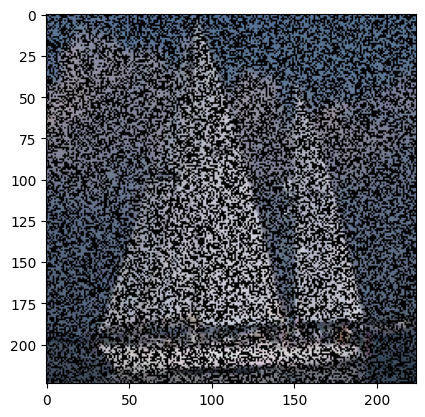

loss: 3.31714
[Sparsity: 0.50, Epoch: 1]acc: 0.357
loss: 2.26326
[Sparsity: 0.50, Epoch: 2]acc: 0.468
loss: 1.54310
[Sparsity: 0.50, Epoch: 3]acc: 0.468
loss: 0.85712
[Sparsity: 0.50, Epoch: 4]acc: 0.508
loss: 0.34034
[Sparsity: 0.50, Epoch: 5]acc: 0.511
loss: 0.07227
[Sparsity: 0.50, Epoch: 6]acc: 0.555
loss: 0.03489
[Sparsity: 0.50, Epoch: 7]acc: 0.547
loss: 0.02287
[Sparsity: 0.50, Epoch: 8]acc: 0.547
loss: 0.01566
[Sparsity: 0.50, Epoch: 9]acc: 0.553
loss: 0.01159
[Sparsity: 0.50, Epoch: 10]acc: 0.550
Finished Training


 55%|█████▌    | 11/20 [19:11<15:51, 105.76s/it]

[Sparsity: 0.50]acc: 0.550


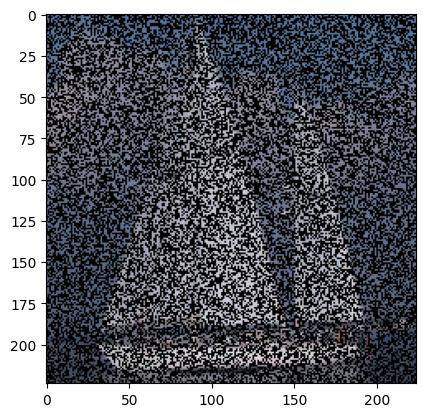

loss: 3.19927
[Sparsity: 0.55, Epoch: 1]acc: 0.417
loss: 2.05018
[Sparsity: 0.55, Epoch: 2]acc: 0.478
loss: 1.21858
[Sparsity: 0.55, Epoch: 3]acc: 0.556
loss: 0.58329
[Sparsity: 0.55, Epoch: 4]acc: 0.573
loss: 0.20447
[Sparsity: 0.55, Epoch: 5]acc: 0.572
loss: 0.03987
[Sparsity: 0.55, Epoch: 6]acc: 0.597
loss: 0.01810
[Sparsity: 0.55, Epoch: 7]acc: 0.603
loss: 0.01162
[Sparsity: 0.55, Epoch: 8]acc: 0.607
loss: 0.00837
[Sparsity: 0.55, Epoch: 9]acc: 0.607
loss: 0.00626
[Sparsity: 0.55, Epoch: 10]acc: 0.600
Finished Training


 60%|██████    | 12/20 [20:58<14:10, 106.27s/it]

[Sparsity: 0.55]acc: 0.600


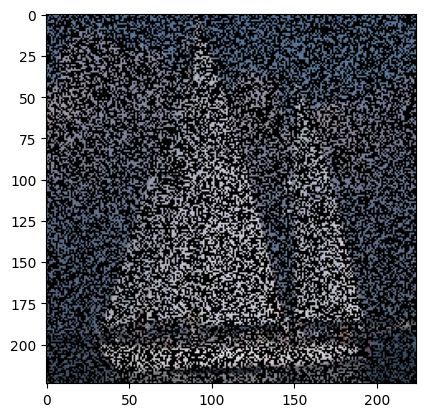

loss: 3.27426
[Sparsity: 0.60, Epoch: 1]acc: 0.378
loss: 2.18938
[Sparsity: 0.60, Epoch: 2]acc: 0.497
loss: 1.41953
[Sparsity: 0.60, Epoch: 3]acc: 0.509
loss: 0.74786
[Sparsity: 0.60, Epoch: 4]acc: 0.540
loss: 0.26495
[Sparsity: 0.60, Epoch: 5]acc: 0.536
loss: 0.05633
[Sparsity: 0.60, Epoch: 6]acc: 0.582
loss: 0.02632
[Sparsity: 0.60, Epoch: 7]acc: 0.585
loss: 0.01660
[Sparsity: 0.60, Epoch: 8]acc: 0.581
loss: 0.01144
[Sparsity: 0.60, Epoch: 9]acc: 0.581
loss: 0.00866
[Sparsity: 0.60, Epoch: 10]acc: 0.585
Finished Training


 65%|██████▌   | 13/20 [22:44<12:22, 106.11s/it]

[Sparsity: 0.60]acc: 0.585


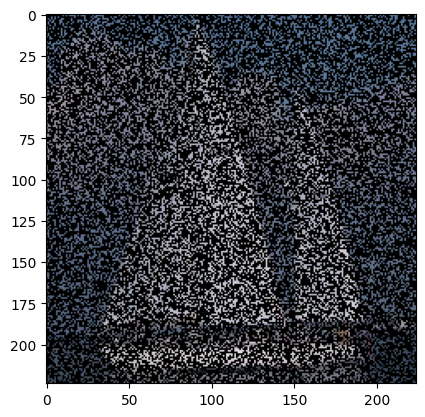

loss: 3.26005
[Sparsity: 0.65, Epoch: 1]acc: 0.392
loss: 2.20244
[Sparsity: 0.65, Epoch: 2]acc: 0.477
loss: 1.42624
[Sparsity: 0.65, Epoch: 3]acc: 0.511
loss: 0.76024
[Sparsity: 0.65, Epoch: 4]acc: 0.528
loss: 0.28194
[Sparsity: 0.65, Epoch: 5]acc: 0.547
loss: 0.05886
[Sparsity: 0.65, Epoch: 6]acc: 0.597
loss: 0.02729
[Sparsity: 0.65, Epoch: 7]acc: 0.598
loss: 0.01785
[Sparsity: 0.65, Epoch: 8]acc: 0.598
loss: 0.01255
[Sparsity: 0.65, Epoch: 9]acc: 0.594
loss: 0.00938
[Sparsity: 0.65, Epoch: 10]acc: 0.591
Finished Training


 70%|███████   | 14/20 [24:31<10:38, 106.43s/it]

[Sparsity: 0.65]acc: 0.591


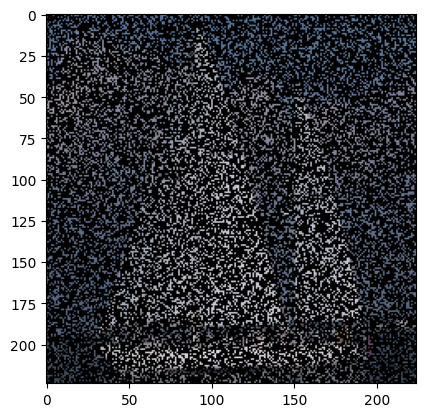

loss: 3.31880
[Sparsity: 0.70, Epoch: 1]acc: 0.391
loss: 2.27194
[Sparsity: 0.70, Epoch: 2]acc: 0.477
loss: 1.54856
[Sparsity: 0.70, Epoch: 3]acc: 0.528
loss: 0.88176
[Sparsity: 0.70, Epoch: 4]acc: 0.530
loss: 0.37164
[Sparsity: 0.70, Epoch: 5]acc: 0.538
loss: 0.09357
[Sparsity: 0.70, Epoch: 6]acc: 0.563
loss: 0.05056
[Sparsity: 0.70, Epoch: 7]acc: 0.560
loss: 0.03296
[Sparsity: 0.70, Epoch: 8]acc: 0.558
loss: 0.02294
[Sparsity: 0.70, Epoch: 9]acc: 0.562
loss: 0.01735
[Sparsity: 0.70, Epoch: 10]acc: 0.563
Finished Training


 75%|███████▌  | 15/20 [26:16<08:49, 105.86s/it]

[Sparsity: 0.70]acc: 0.563


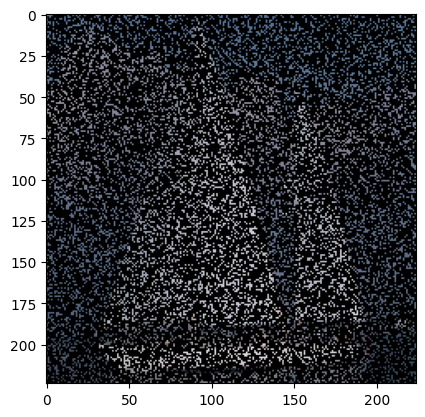

loss: 3.36504
[Sparsity: 0.75, Epoch: 1]acc: 0.377
loss: 2.40501
[Sparsity: 0.75, Epoch: 2]acc: 0.453
loss: 1.67919
[Sparsity: 0.75, Epoch: 3]acc: 0.519
loss: 0.99430
[Sparsity: 0.75, Epoch: 4]acc: 0.537
loss: 0.43191
[Sparsity: 0.75, Epoch: 5]acc: 0.524
loss: 0.10295
[Sparsity: 0.75, Epoch: 6]acc: 0.543
loss: 0.05672
[Sparsity: 0.75, Epoch: 7]acc: 0.546
loss: 0.03669
[Sparsity: 0.75, Epoch: 8]acc: 0.540
loss: 0.02490
[Sparsity: 0.75, Epoch: 9]acc: 0.540
loss: 0.01837
[Sparsity: 0.75, Epoch: 10]acc: 0.540
Finished Training


 80%|████████  | 16/20 [28:01<07:02, 105.70s/it]

[Sparsity: 0.75]acc: 0.540


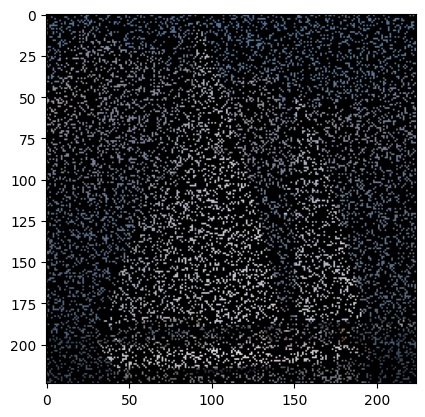

loss: 3.36107
[Sparsity: 0.80, Epoch: 1]acc: 0.382
loss: 2.34878
[Sparsity: 0.80, Epoch: 2]acc: 0.453
loss: 1.59832
[Sparsity: 0.80, Epoch: 3]acc: 0.480
loss: 0.87796
[Sparsity: 0.80, Epoch: 4]acc: 0.512
loss: 0.34170
[Sparsity: 0.80, Epoch: 5]acc: 0.505
loss: 0.06316
[Sparsity: 0.80, Epoch: 6]acc: 0.535
loss: 0.02847
[Sparsity: 0.80, Epoch: 7]acc: 0.539
loss: 0.01806
[Sparsity: 0.80, Epoch: 8]acc: 0.542
loss: 0.01274
[Sparsity: 0.80, Epoch: 9]acc: 0.542
loss: 0.00937
[Sparsity: 0.80, Epoch: 10]acc: 0.541
Finished Training


 85%|████████▌ | 17/20 [29:44<05:14, 104.89s/it]

[Sparsity: 0.80]acc: 0.541


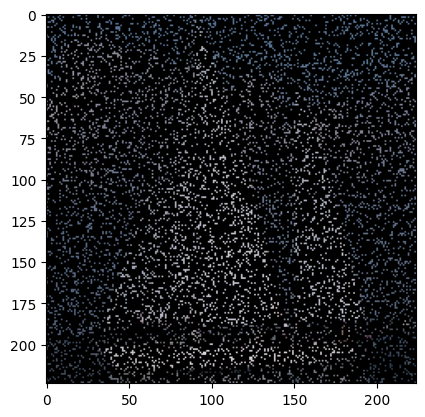

loss: 3.29686
[Sparsity: 0.85, Epoch: 1]acc: 0.387
loss: 2.33472
[Sparsity: 0.85, Epoch: 2]acc: 0.449
loss: 1.62482
[Sparsity: 0.85, Epoch: 3]acc: 0.486
loss: 0.93412
[Sparsity: 0.85, Epoch: 4]acc: 0.521
loss: 0.36891
[Sparsity: 0.85, Epoch: 5]acc: 0.520
loss: 0.07967
[Sparsity: 0.85, Epoch: 6]acc: 0.536
loss: 0.04127
[Sparsity: 0.85, Epoch: 7]acc: 0.532
loss: 0.02548
[Sparsity: 0.85, Epoch: 8]acc: 0.530
loss: 0.01791
[Sparsity: 0.85, Epoch: 9]acc: 0.533
loss: 0.01469
[Sparsity: 0.85, Epoch: 10]acc: 0.535
Finished Training


 90%|█████████ | 18/20 [31:28<03:29, 104.54s/it]

[Sparsity: 0.85]acc: 0.535


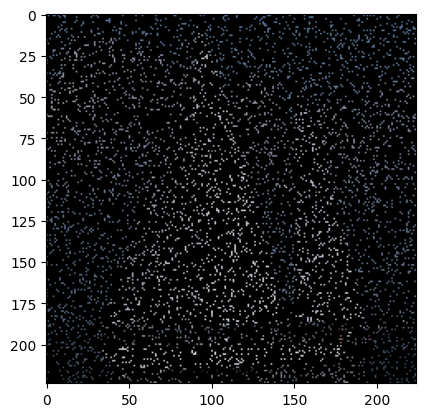

loss: 3.34044
[Sparsity: 0.90, Epoch: 1]acc: 0.387
loss: 2.35516
[Sparsity: 0.90, Epoch: 2]acc: 0.450
loss: 1.67214
[Sparsity: 0.90, Epoch: 3]acc: 0.476
loss: 0.98870
[Sparsity: 0.90, Epoch: 4]acc: 0.484
loss: 0.41157
[Sparsity: 0.90, Epoch: 5]acc: 0.474
loss: 0.08734
[Sparsity: 0.90, Epoch: 6]acc: 0.511
loss: 0.04243
[Sparsity: 0.90, Epoch: 7]acc: 0.514
loss: 0.02948
[Sparsity: 0.90, Epoch: 8]acc: 0.510
loss: 0.01966
[Sparsity: 0.90, Epoch: 9]acc: 0.516
loss: 0.01559
[Sparsity: 0.90, Epoch: 10]acc: 0.517
Finished Training


 95%|█████████▌| 19/20 [33:10<01:43, 103.98s/it]

[Sparsity: 0.90]acc: 0.517


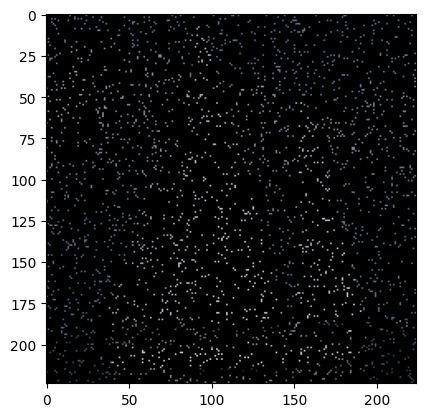

loss: 3.52002
[Sparsity: 0.95, Epoch: 1]acc: 0.331
loss: 2.60654
[Sparsity: 0.95, Epoch: 2]acc: 0.393
loss: 1.97239
[Sparsity: 0.95, Epoch: 3]acc: 0.420
loss: 1.19741
[Sparsity: 0.95, Epoch: 4]acc: 0.410
loss: 0.41262
[Sparsity: 0.95, Epoch: 5]acc: 0.389
loss: 0.06167
[Sparsity: 0.95, Epoch: 6]acc: 0.414
loss: 0.02878
[Sparsity: 0.95, Epoch: 7]acc: 0.421
loss: 0.01696
[Sparsity: 0.95, Epoch: 8]acc: 0.422
loss: 0.01229
[Sparsity: 0.95, Epoch: 9]acc: 0.423
loss: 0.00926
[Sparsity: 0.95, Epoch: 10]acc: 0.429
Finished Training


100%|██████████| 20/20 [34:53<00:00, 104.70s/it]

[Sparsity: 0.95]acc: 0.429


In [ ]:
prob_list = np.arange(0, 1, 0.05)
acc_sparseconv = []
batch_size = 64

for prob in tqdm(prob_list):
  train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
  test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))


  trainset = SparseConvNetDataset(train_data, train_targets, device, train_mask)
  testset = SparseConvNetDataset(test_data, test_targets, device, test_mask)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
  plt.imshow(testset[0][0][:3].detach().cpu().permute(1, 2, 0))
  plt.show()

  net = SparseConvNet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  for epoch in range(10):
      if epoch==5:
            optimizer = optim.Adam(net.parameters(), lr=0.0001)
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % 20 == 19:
        #       print('[%d, %5d] loss: %.5f' %
        #             (epoch + 1, i + 1, running_loss / 20))
        #       running_loss = 0.0
      print('loss: %.5f' % (running_loss / i))
      running_loss = 0.0
      print('[Sparsity: %.2f, Epoch: %d]acc: %.3f' % (prob, epoch + 1, model_test(net, testloader)))

  print('Finished Training')
  acc_sparseconv.append(model_test(net, testloader))
  print('[Sparsity: %.2f]acc: %.3f' % (prob, acc_sparseconv[-1]))

In [ ]:
print(acc_sparseconv)

[0.6699308755760369, 0.6342165898617511, 0.6509216589861752, 0.6405529953917051, 0.6359447004608295, 0.6232718894009217, 0.6284562211981567, 0.6382488479262672, 0.6002304147465438, 0.6013824884792627, 0.5501152073732719, 0.6002304147465438, 0.5846774193548387, 0.5910138248847926, 0.5627880184331797, 0.5403225806451613, 0.5414746543778802, 0.5345622119815668, 0.5167050691244239, 0.42914746543778803]


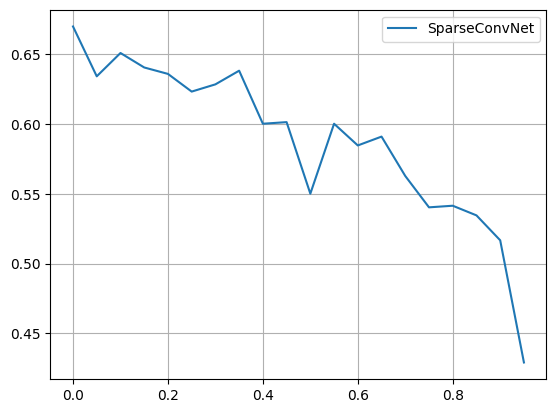

In [ ]:
plt.plot(prob_list, acc_sparseconv, label='SparseConvNet')
plt.grid()
plt.legend()